In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", palette="muted")


In [3]:
# Main application data
app_train = pd.read_csv("../raw/application_train.csv")
app_test  = pd.read_csv("../raw/application_test.csv")

# Bureau data
bureau = pd.read_csv("../raw/bureau.csv")
bureau_balance = pd.read_csv("../raw/bureau_balance.csv")

# Credit card balances
credit_card = pd.read_csv("../raw/credit_card_balance.csv")

# POS cash balances
pos = pd.read_csv("../raw/POS_CASH_balance.csv")

# Installments payments
installments = pd.read_csv("../raw/installments_payments.csv")

# Previous applications
previous_app = pd.read_csv("../raw/previous_application.csv")


In [4]:
# Basic info
print("Train shape:", app_train.shape)
print("Test shape:", app_test.shape)

# Peek at data
print(app_train.head())

# Target distribution
print(app_train["TARGET"].value_counts(normalize=True))


Train shape: (307511, 122)
Test shape: (48744, 121)
   SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   ...  FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_

In [5]:
bureau_features = bureau.groupby("SK_ID_CURR").agg({
    "CREDIT_ACTIVE": lambda x: (x=="Active").sum(),
    "CREDIT_DAY_OVERDUE": "mean",
    "AMT_CREDIT_SUM": "sum"
}).reset_index()

bureau_features.rename(columns={
    "CREDIT_ACTIVE":"NUM_ACTIVE_LOANS",
    "CREDIT_DAY_OVERDUE":"AVG_DAYS_OVERDUE",
    "AMT_CREDIT_SUM":"TOTAL_CREDIT_SUM"
}, inplace=True)

print(bureau_features.head())


   SK_ID_CURR  NUM_ACTIVE_LOANS  AVG_DAYS_OVERDUE  TOTAL_CREDIT_SUM
0      100001                 3               0.0       1453365.000
1      100002                 2               0.0        865055.565
2      100003                 1               0.0       1017400.500
3      100004                 0               0.0        189037.800
4      100005                 2               0.0        657126.000


In [6]:
credit_card["UTILIZATION"] = credit_card["AMT_BALANCE"] / credit_card["AMT_CREDIT_LIMIT_ACTUAL"]

credit_card_features = credit_card.groupby("SK_ID_CURR").agg({
    "UTILIZATION":"mean",
    "AMT_PAYMENT_TOTAL_CURRENT":"mean",
    "SK_DPD":"mean"
}).reset_index()

credit_card_features.rename(columns={
    "UTILIZATION":"AVG_UTILIZATION",
    "AMT_PAYMENT_TOTAL_CURRENT":"AVG_PAYMENT",
    "SK_DPD":"AVG_DAYS_PAST_DUE"
}, inplace=True)

print(credit_card_features.head())


   SK_ID_CURR  AVG_UTILIZATION  AVG_PAYMENT  AVG_DAYS_PAST_DUE
0      100006         0.000000     0.000000           0.000000
1      100011         0.302678  4520.067568           0.000000
2      100013         0.115301  6817.172344           0.010417
3      100021         0.000000     0.000000           0.000000
4      100023         0.000000     0.000000           0.000000


In [7]:
pos_features = pos.groupby("SK_ID_CURR").agg({
    "SK_DPD":"mean",
    "SK_DPD_DEF":"mean"
}).reset_index()

pos_features.rename(columns={
    "SK_DPD":"AVG_POS_DAYS_PAST_DUE",
    "SK_DPD_DEF":"AVG_POS_DEF"
}, inplace=True)

print(pos_features.head())


   SK_ID_CURR  AVG_POS_DAYS_PAST_DUE  AVG_POS_DEF
0      100001               0.777778     0.777778
1      100002               0.000000     0.000000
2      100003               0.000000     0.000000
3      100004               0.000000     0.000000
4      100005               0.000000     0.000000


In [8]:
pos_features = pos.groupby("SK_ID_CURR").agg({
    "SK_DPD":"mean",
    "SK_DPD_DEF":"mean"
}).reset_index()

pos_features.rename(columns={
    "SK_DPD":"AVG_POS_DAYS_PAST_DUE",
    "SK_DPD_DEF":"AVG_POS_DEF"
}, inplace=True)

print(pos_features.head())


   SK_ID_CURR  AVG_POS_DAYS_PAST_DUE  AVG_POS_DEF
0      100001               0.777778     0.777778
1      100002               0.000000     0.000000
2      100003               0.000000     0.000000
3      100004               0.000000     0.000000
4      100005               0.000000     0.000000


In [10]:
# Payment ratio (paid vs installment amount)
installments["PAYMENT_RATIO"] = installments["AMT_PAYMENT"] / installments["AMT_INSTALMENT"]

# Late payment flag (payment date vs scheduled date)
installments["LATE"] = (installments["DAYS_ENTRY_PAYMENT"] > installments["DAYS_INSTALMENT"]).astype(int)

# Aggregate per customer
install_features = installments.groupby("SK_ID_CURR").agg({
    "PAYMENT_RATIO":"mean",
    "LATE":"mean"
}).reset_index()

install_features.rename(columns={
    "PAYMENT_RATIO":"AVG_PAYMENT_RATIO",
    "LATE":"LATE_PAYMENT_RATE"
}, inplace=True)

print(install_features.head())


   SK_ID_CURR  AVG_PAYMENT_RATIO  LATE_PAYMENT_RATE
0      100001                1.0           0.142857
1      100002                1.0           0.000000
2      100003                1.0           0.000000
3      100004                1.0           0.000000
4      100005                1.0           0.111111


In [11]:
features = app_train[["SK_ID_CURR","TARGET"]].merge(bureau_features, on="SK_ID_CURR", how="left")
features = features.merge(credit_card_features, on="SK_ID_CURR", how="left")
features = features.merge(pos_features, on="SK_ID_CURR", how="left")
features = features.merge(install_features, on="SK_ID_CURR", how="left")

print(features.head())


   SK_ID_CURR  TARGET  NUM_ACTIVE_LOANS  AVG_DAYS_OVERDUE  TOTAL_CREDIT_SUM  \
0      100002       1               2.0               0.0        865055.565   
1      100003       0               1.0               0.0       1017400.500   
2      100004       0               0.0               0.0        189037.800   
3      100006       0               NaN               NaN               NaN   
4      100007       0               0.0               0.0        146250.000   

   AVG_UTILIZATION  AVG_PAYMENT  AVG_DAYS_PAST_DUE  AVG_POS_DAYS_PAST_DUE  \
0              NaN          NaN                NaN                    0.0   
1              NaN          NaN                NaN                    0.0   
2              NaN          NaN                NaN                    0.0   
3              0.0          0.0                0.0                    0.0   
4              NaN          NaN                NaN                    0.0   

   AVG_POS_DEF  AVG_PAYMENT_RATIO  LATE_PAYMENT_RATE  
0      

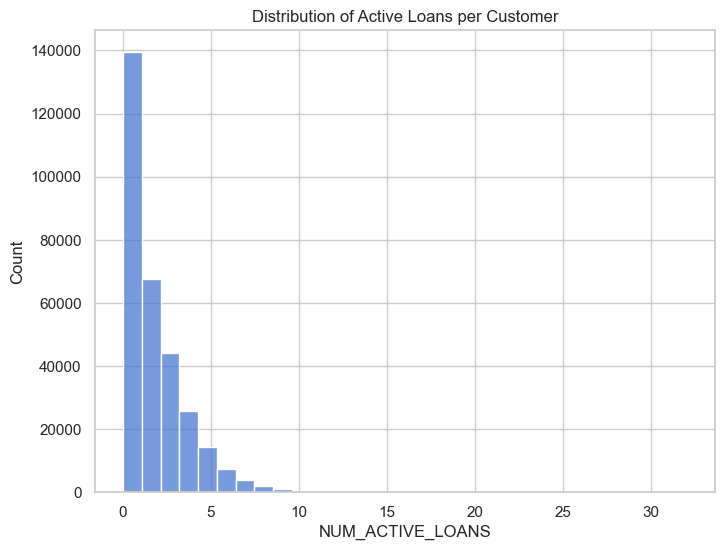

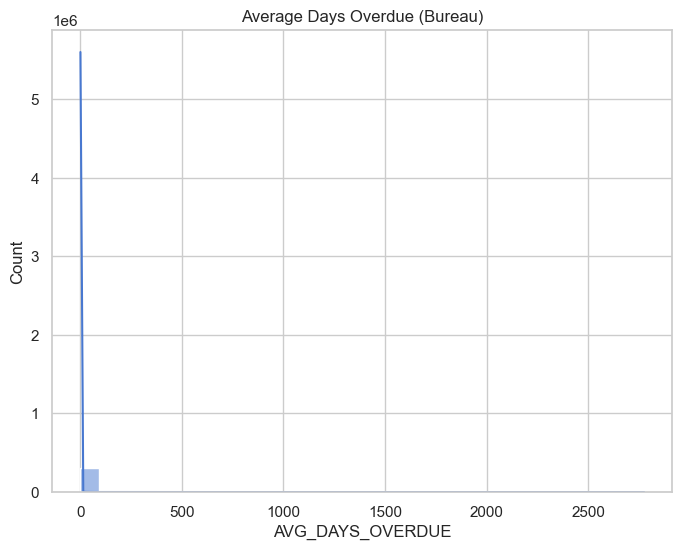

In [12]:
plt.figure(figsize=(8,6))
sns.histplot(bureau_features["NUM_ACTIVE_LOANS"], bins=30, kde=False)
plt.title("Distribution of Active Loans per Customer")
plt.show()

plt.figure(figsize=(8,6))
sns.histplot(bureau_features["AVG_DAYS_OVERDUE"], bins=30, kde=True)
plt.title("Average Days Overdue (Bureau)")
plt.show()


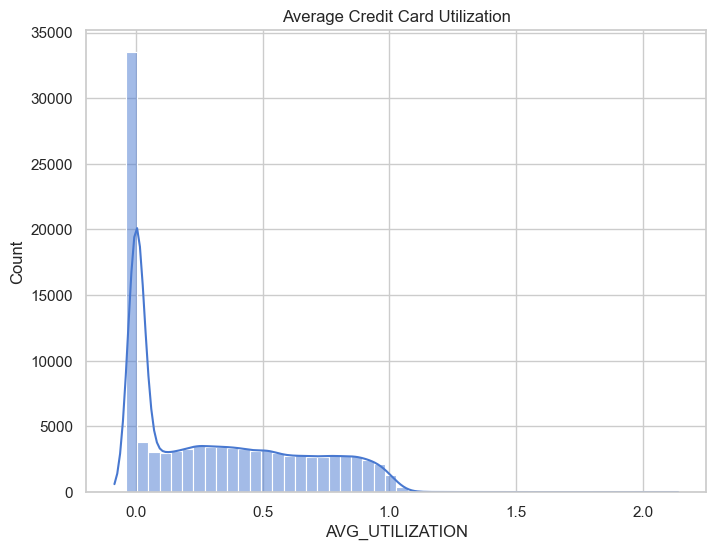

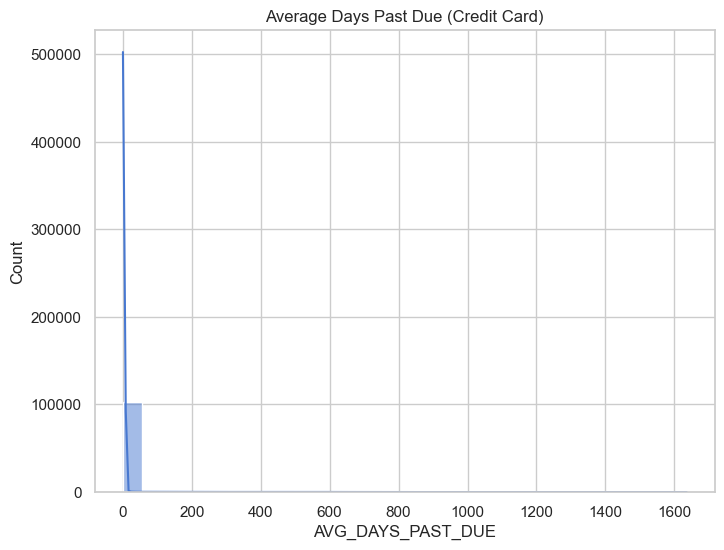

In [13]:
plt.figure(figsize=(8,6))
sns.histplot(credit_card_features["AVG_UTILIZATION"], bins=50, kde=True)
plt.title("Average Credit Card Utilization")
plt.show()

plt.figure(figsize=(8,6))
sns.histplot(credit_card_features["AVG_DAYS_PAST_DUE"], bins=30, kde=True)
plt.title("Average Days Past Due (Credit Card)")
plt.show()


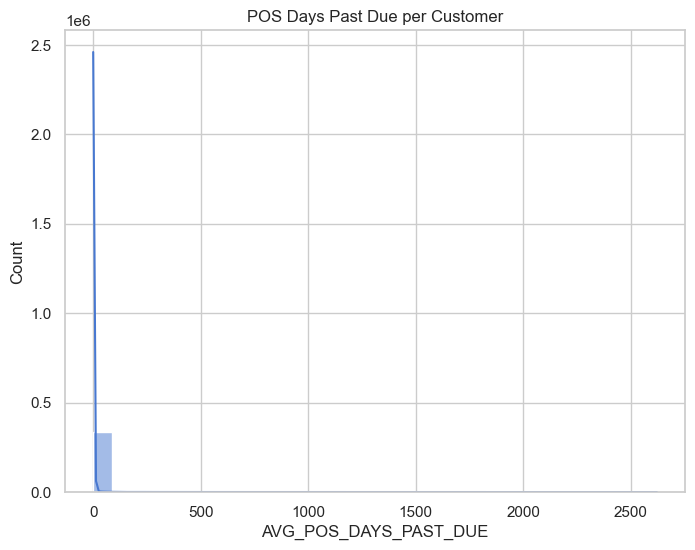

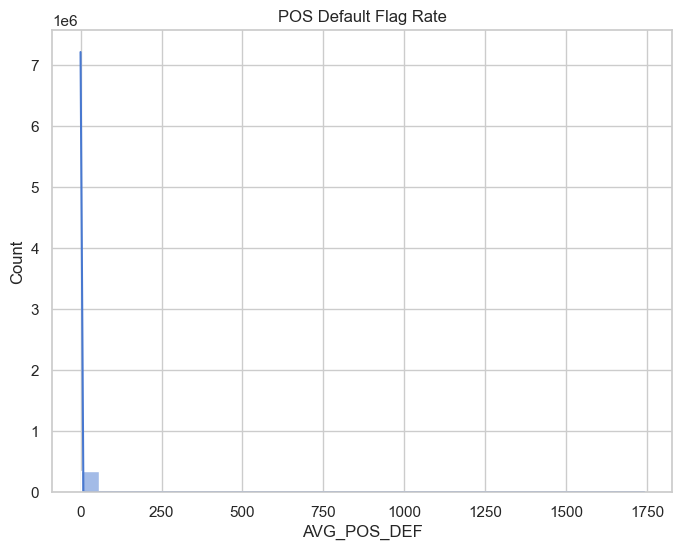

In [14]:
plt.figure(figsize=(8,6))
sns.histplot(pos_features["AVG_POS_DAYS_PAST_DUE"], bins=30, kde=True)
plt.title("POS Days Past Due per Customer")
plt.show()

plt.figure(figsize=(8,6))
sns.histplot(pos_features["AVG_POS_DEF"], bins=30, kde=True)
plt.title("POS Default Flag Rate")
plt.show()


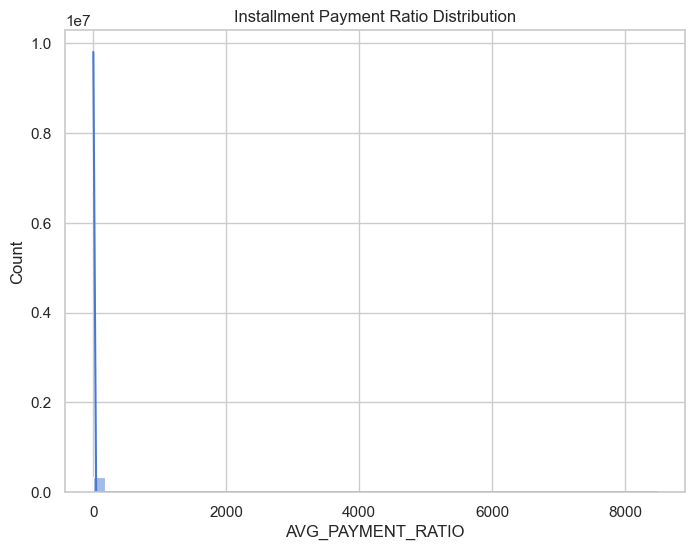

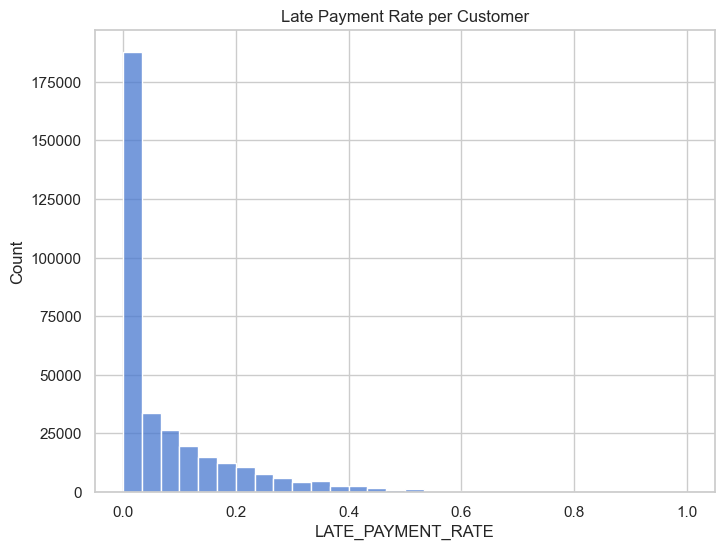

In [15]:
plt.figure(figsize=(8,6))
sns.histplot(install_features["AVG_PAYMENT_RATIO"], bins=50, kde=True)
plt.title("Installment Payment Ratio Distribution")
plt.show()

plt.figure(figsize=(8,6))
sns.histplot(install_features["LATE_PAYMENT_RATE"], bins=30, kde=False)
plt.title("Late Payment Rate per Customer")
plt.show()


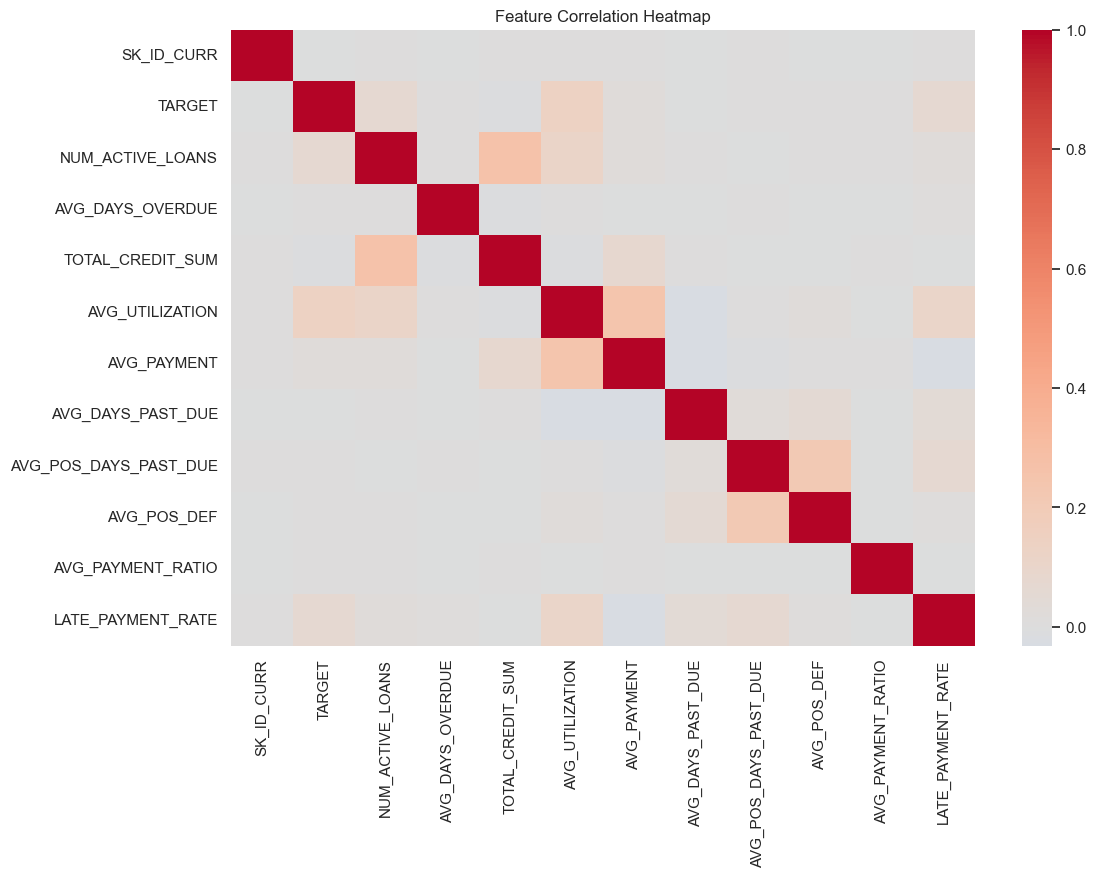

In [16]:
plt.figure(figsize=(12,8))
sns.heatmap(features.corr(), cmap="coolwarm", center=0)
plt.title("Feature Correlation Heatmap")
plt.show()


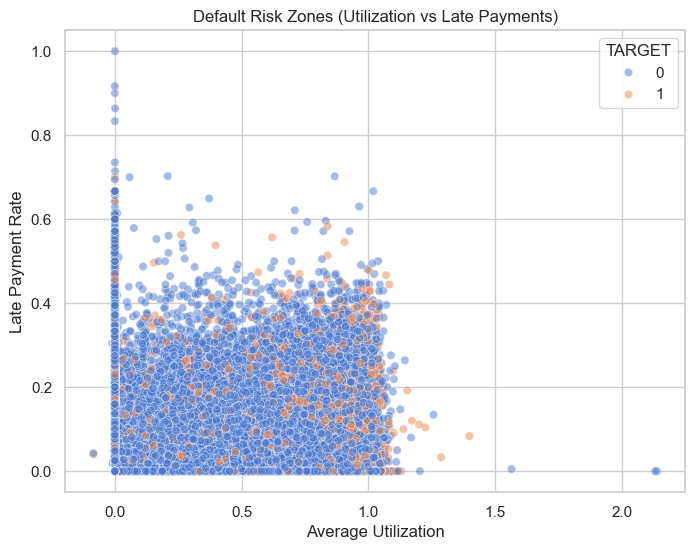

In [17]:
# Example: Late payment vs default
merged = features[["TARGET","LATE_PAYMENT_RATE","AVG_UTILIZATION"]].dropna()

plt.figure(figsize=(8,6))
sns.scatterplot(x="AVG_UTILIZATION", y="LATE_PAYMENT_RATE", hue="TARGET", data=merged, alpha=0.5)
plt.title("Default Risk Zones (Utilization vs Late Payments)")
plt.xlabel("Average Utilization")
plt.ylabel("Late Payment Rate")
plt.show()


C:\Users\SOUPARNO\AppData\Local\Temp\ipykernel_24084\3326674242.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  income_groups = app_train.groupby("INCOME_BUCKET")["TARGET"].mean().reset_index()


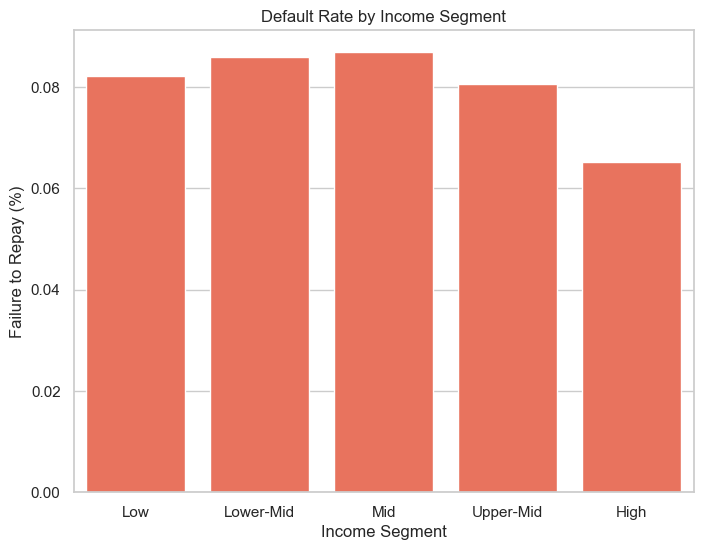

In [18]:
# Income buckets (quintiles)
app_train["INCOME_BUCKET"] = pd.qcut(app_train["AMT_INCOME_TOTAL"], 5, labels=["Low","Lower-Mid","Mid","Upper-Mid","High"])

income_groups = app_train.groupby("INCOME_BUCKET")["TARGET"].mean().reset_index()

plt.figure(figsize=(8,6))
sns.barplot(x="INCOME_BUCKET", y="TARGET", data=income_groups, color="tomato")
plt.ylabel("Failure to Repay (%)")
plt.xlabel("Income Segment")
plt.title("Default Rate by Income Segment")
plt.show()


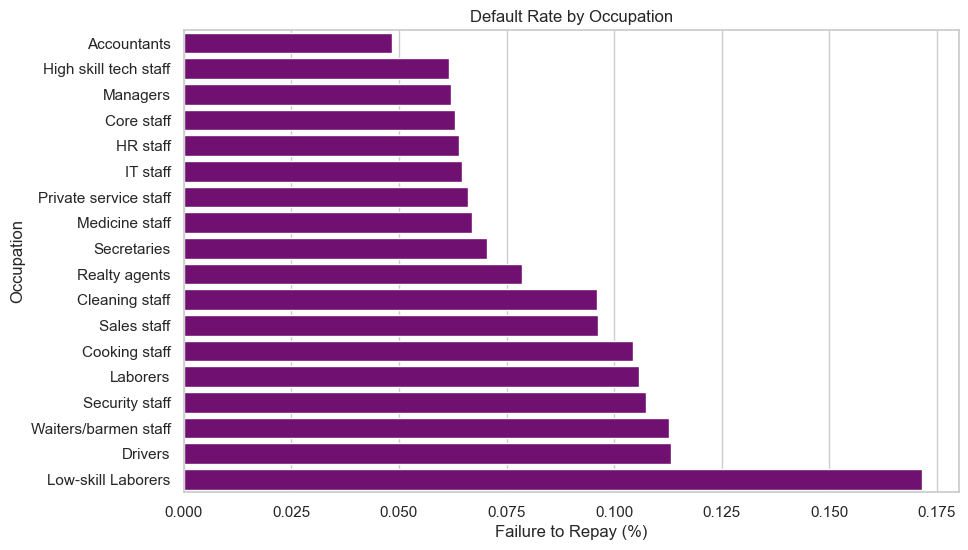

In [19]:
occ_groups = app_train.groupby("OCCUPATION_TYPE")["TARGET"].mean().sort_values().reset_index()

plt.figure(figsize=(10,6))
sns.barplot(y="OCCUPATION_TYPE", x="TARGET", data=occ_groups, color="purple")
plt.xlabel("Failure to Repay (%)")
plt.ylabel("Occupation")
plt.title("Default Rate by Occupation")
plt.show()
